In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

# **Подготовка данных**

In [2]:
# Загрузим данные
contracts = pd.read_excel('data/CASE_CONTRACTS.xlsx')
losses = pd.read_excel('data/CASE_LOSSES.xlsx')
experiment_group = pd.read_excel('data/experiment_group.xlsx')

In [3]:
# Посмотрим на размеры датафреймов
dfs = [contracts, losses, experiment_group]
for df in dfs:
    print(df.shape)

(3711, 10)
(45, 4)
(14842, 3)


In [4]:
# Объединим данные в одну таблицу
data = experiment_group.merge(
        contracts, on='client_id', how='left').merge(
        losses, on='client_id', how='left')
data.head()

,client_id,group,experiment_id,contract_id,contract_num,product_name,contract_status,currency_name,duration,country,price,insurance_amount,loss_id,loss_name,loss_payout_amt
0,10001718,control,policy_pricing,2.123569e+08,ТТЕ7227715*****,Страхование путешественников,Действует,Российский рубль,14.0,Египет,3836.0,5000000.0,NaN,NaN,NaN
1,1017180395,control,policy_pricing,2.135234e+07,ДСЖ-5/1539*****,Страхование путешественников,Действует,Российский рубль,7.0,Таиланд,1918.0,5000000.0,NaN,NaN,NaN
2,1017178047,control,policy_pricing,2.147454e+09,ТМБЕ579 № *****,Страхование путешественников,Действует,Российский рубль,14.0,Египет,3836.0,5000000.0,NaN,NaN,NaN
3,1017174614,control,policy_pricing,2.135192e+07,ТМГ1535Е7 *****,Страхование путешественников,Действует,Российский рубль,7.0,Таиланд,1918.0,5000000.0,NaN,NaN,NaN
4,1017174071,control,policy_pricing,2.162434e+08,ТТЕ7227777*****,Страхование путешественников,Завершен,Российский рубль,10.0,Канада,1096.0,2000000.0,NaN,NaN,NaN


In [5]:
# Конвертируем рубли в доллары
def converter(amount, currency, rate=80):
    if currency == 'Российский рубль':
        if amount > 0:
            return int(amount / rate)
    else:
        return amount


data['price_usd'] = data.apply(lambda row: converter(row['price'], row['currency_name']), axis=1)
data['insurance_amount_usd'] = data.apply(lambda row: converter(row['insurance_amount'], row['currency_name']), axis=1)
data['loss_payout_amt_usd'] = data.apply(lambda row: converter(row['loss_payout_amt'], row['currency_name']), axis=1)
data.head()

,client_id,group,experiment_id,contract_id,contract_num,product_name,contract_status,currency_name,duration,country,price,insurance_amount,loss_id,loss_name,loss_payout_amt,price_usd,insurance_amount_usd,loss_payout_amt_usd
0,10001718,control,policy_pricing,2.123569e+08,ТТЕ7227715*****,Страхование путешественников,Действует,Российский рубль,14.0,Египет,3836.0,5000000.0,NaN,NaN,NaN,47.0,62500.0,NaN
1,1017180395,control,policy_pricing,2.135234e+07,ДСЖ-5/1539*****,Страхование путешественников,Действует,Российский рубль,7.0,Таиланд,1918.0,5000000.0,NaN,NaN,NaN,23.0,62500.0,NaN
2,1017178047,control,policy_pricing,2.147454e+09,ТМБЕ579 № *****,Страхование путешественников,Действует,Российский рубль,14.0,Египет,3836.0,5000000.0,NaN,NaN,NaN,47.0,62500.0,NaN
3,1017174614,control,policy_pricing,2.135192e+07,ТМГ1535Е7 *****,Страхование путешественников,Действует,Российский рубль,7.0,Таиланд,1918.0,5000000.0,NaN,NaN,NaN,23.0,62500.0,NaN
4,1017174071,control,policy_pricing,2.162434e+08,ТТЕ7227777*****,Страхование путешественников,Завершен,Российский рубль,10.0,Канада,1096.0,2000000.0,NaN,NaN,NaN,13.0,25000.0,NaN


In [6]:
# Создадим флаги для потерь и конверсий
data['loss_cnt'] = data['loss_payout_amt_usd'].apply(lambda x: 1 if x > 0 else 0)
data['converted'] = data['price'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
# Посмотрим на распределение данных
data.describe()

,client_id,contract_id,duration,price,insurance_amount,loss_id,loss_payout_amt,price_usd,insurance_amount_usd,loss_payout_amt_usd,loss_cnt,converted
count,1.484200e+04,3.711000e+03,3711.000000,3711.000000,3.711000e+03,45.000000,4.500000e+01,3711.000000,3711.000000,45.000000,14842.000000,14842.000000
mean,5.720898e+09,8.934257e+08,24.120453,4167.948262,3.296200e+06,23.000000,2.226667e+05,58.307195,43916.734034,3880.555556,0.003032,0.250034
std,4.761103e+09,2.727517e+09,60.085485,9555.133845,1.511247e+06,13.133926,3.539158e+05,153.057421,19400.866063,6452.457004,0.054981,0.433047
min,1.000172e+07,2.111122e+07,7.000000,27.000000,5.000000e+04,1.000000,2.000000e+04,6.000000,12500.000000,250.000000,0.000000,0.000000
25%,1.001189e+09,2.127130e+08,10.000000,1096.000000,2.000000e+06,12.000000,5.000000e+04,13.000000,25000.000000,625.000000,0.000000,0.000000
50%,1.000931e+10,2.138622e+08,14.000000,1918.000000,3.000000e+06,23.000000,8.000000e+04,23.000000,37500.000000,1250.000000,0.000000,0.000000
75%,1.011676e+10,2.364878e+08,14.000000,3836.000000,5.000000e+06,34.000000,1.500000e+05,47.000000,62500.000000,2500.000000,0.000000,0.750000
max,1.199690e+10,3.113393e+10,365.000000,60000.000000,5.000000e+06,45.000000,1.500000e+06,2000.000000,100000.000000,30000.000000,1.000000,1.000000


In [8]:
# Уберём выбросы
q95 = data.price_usd.quantile(0.95)
data['price_usd'] = data['price_usd'].apply(lambda x: q95 if x > q95 else x)

<Axes: title={'center': 'price_usd'}, xlabel='group'>

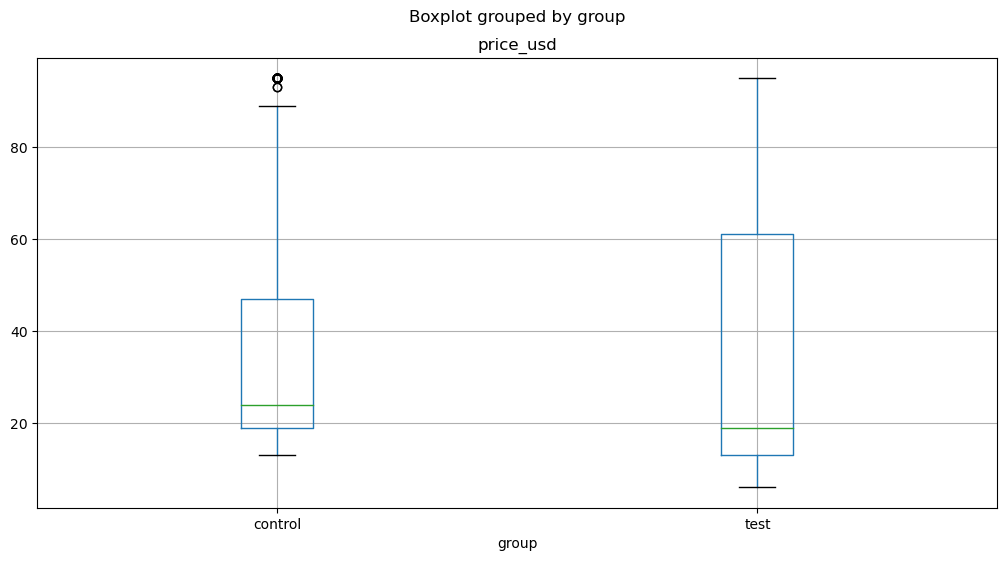

In [9]:
data.boxplot('price_usd', by='group', figsize=(12, 6))

In [10]:
# Удалим лишние столбцы
df = data.drop(['experiment_id', 'contract_id', 'contract_num', 'product_name', 'duration',
                'currency_name', 'country', 'price', 'insurance_amount', 'loss_id', 
                'loss_name', 'loss_payout_amt', 'contract_status',], axis=1)

In [11]:
# Посмотрим на типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             14842 non-null  int64  
 1   group                 12349 non-null  object 
 2   price_usd             3711 non-null   float64
 3   insurance_amount_usd  3711 non-null   float64
 4   loss_payout_amt_usd   45 non-null     float64
 5   loss_cnt              14842 non-null  int64  
 6   converted             14842 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 927.6+ KB


In [12]:
# Удалим строки с пропусками в столбце group
df = df.dropna(subset=['group'])

# Заполним пропуски в числовых признаках значением 0 и изменим тип данных
cols = ['price_usd', 'insurance_amount_usd', 'loss_payout_amt_usd']
for col in cols:
    df[col] = df[col].fillna(0).astype('int')

df.reset_index(drop=True, inplace=True)
df.head()

,client_id,group,price_usd,insurance_amount_usd,loss_payout_amt_usd,loss_cnt,converted
0,10001718,control,47,62500,0,0,1
1,1017180395,control,23,62500,0,0,1
2,1017178047,control,47,62500,0,0,1
3,1017174614,control,23,62500,0,0,1
4,1017174071,control,13,25000,0,0,1


In [13]:
# Сгруппируем данные
group = df.groupby('group').agg({'client_id':'count','price_usd': 'sum', 'insurance_amount_usd': 'sum', 
                                 'loss_payout_amt_usd': 'sum', 'loss_cnt': 'sum', 'converted': 'sum'}).reset_index()
                                 
group['conversion_rate'] = group['converted'] / group['client_id']
group['avg_price'] = group['price_usd'] / group['converted']
group['avg_insurance_amount'] = group['insurance_amount_usd'] / group['converted']
group['avg_loss_payout_amt'] = group['loss_payout_amt_usd'] / group['loss_cnt']
group

,group,client_id,price_usd,insurance_amount_usd,loss_payout_amt_usd,loss_cnt,converted,conversion_rate,avg_price,avg_insurance_amount,avg_loss_payout_amt
0,control,6043,65064,92337500,79750,30,1949,0.322522,33.383273,47376.859928,2658.333333
1,test,6306,57982,64662500,92375,14,1667,0.264351,34.782244,38789.742052,6598.214286


# **Проверка гипотез**

## **Равенство пропорций**
### - H0: Наблюдаемые пропорции выборок соответствуют ожидаемым теоретическим пропорциям.
### - H1: Наблюдаемые пропорции выборок не соответствуют ожидаемым теоретическим пропорциям.

In [14]:
# SRM тест
control = group['client_id'][0]
test = group['client_id'][1]
total = test + control
observed = [test, control]
expected = [total/2, total/2]
alpha = 0.01

stats, pvalue = st.chisquare(observed, f_exp = expected)

print('p-value равно', pvalue)

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value равно 0.017948361469529415
Не получилось отвергнуть нулевую гипотезу


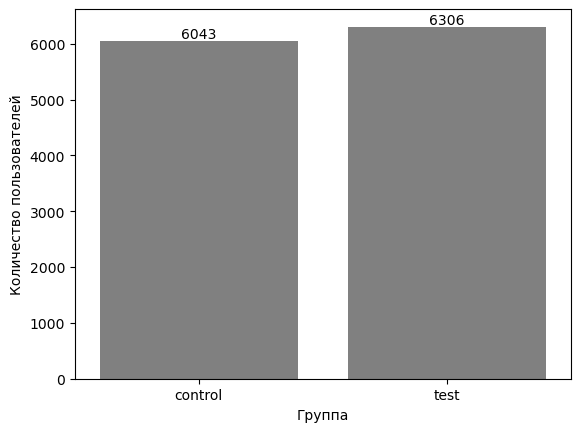

In [15]:
# Визуализируем количество пользователей в каждой группе 
sns.barplot(x='group', y='client_id', data=group, color='grey')
# Добавим подписи сверху столбцов
for i in range(2):
    plt.text(x=i, y=group['client_id'][i]+50, s=group['client_id'][i], horizontalalignment='center')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.show()


### Пропорции клиентов в группах не отличаются

## **Конверсия**
### - H0: Конверсия контрольной группы равна конверсии тестовой группы
### - H1: Конверсия контрольной группы не равна конверсии тестовой группы

In [16]:
# Проводим z-тест на равенство пропорций
count = np.array([group['converted'][0], group['converted'][1]])
nobs = np.array([group['client_id'][0], group['client_id'][1]])
alpha = 0.01

stats, pvalue = proportions_ztest(count, nobs, alternative='two-sided')

print('p-value равно', pvalue)

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value равно 1.2376025494738044e-12
Отвергаем нулевую гипотезу


In [17]:
# На сколько процентов изменилась конверсия в оформления в тестовой группе по отношению к контрольной
control = group['conversion_rate'][0]
test = group['conversion_rate'][1]
print('Изменение конверсии в тестовой группе по отношению к контрольной: {:.1%}'.format(test/control-1))

Изменение конверсии в тестовой группе по отношению к контрольной: -18.0%


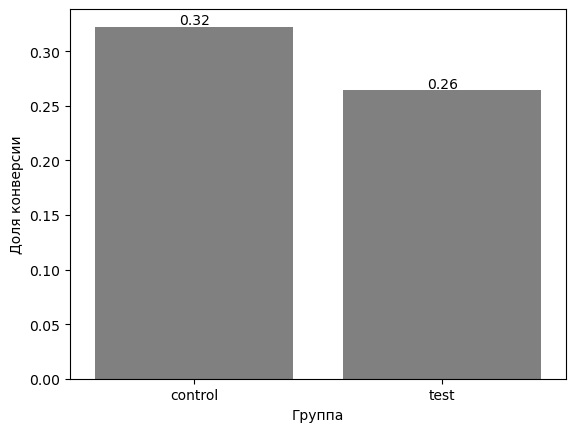

In [18]:
# Визуализируем конверсию по группам
sns.barplot(x='group', y='conversion_rate', data=group, color='grey')
# Добавим подписи сверху столбцов
for i in range(2):
    plt.text(x=i, y=group['conversion_rate'][i]+0.002, s=round(group['conversion_rate'][i],2), horizontalalignment='center')
plt.xlabel('Группа')
plt.ylabel('Доля конверсии')
plt.show()

## **Цена полиса**

### - H0: Средняя цена полиса для контрольной и тестовой группы не отличается
### - H1: Средняя цена полиса для контрольной и тестовой группы отличается

In [19]:
# Проведём t-тест для проверки гипотезы о равенстве цен полиса в группах
control_price = df[(df['group'] == 'control') & (df['converted'] == 1)]['price_usd']
test_price = df[(df['group'] == 'test') & (df['converted'] == 1)]['price_usd']
alpha = 0.01

stats, pvalue = st.ttest_ind(control_price, test_price, equal_var = False)

print('p-value равно', pvalue)

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value равно 0.08169860997398731
Не получилось отвергнуть нулевую гипотезу


In [20]:
# На сколько процентов изменилась цена полиса в тестовой группе по отношению к контрольной
control = group['avg_price'][0]
test = group['avg_price'][1]

print('Наблюдаемое изменение цены полиса в тестовой группе по отношению к контрольной: {:.1%}'.format((test/control)-1))

Наблюдаемое изменение цены полиса в тестовой группе по отношению к контрольной: 4.2%


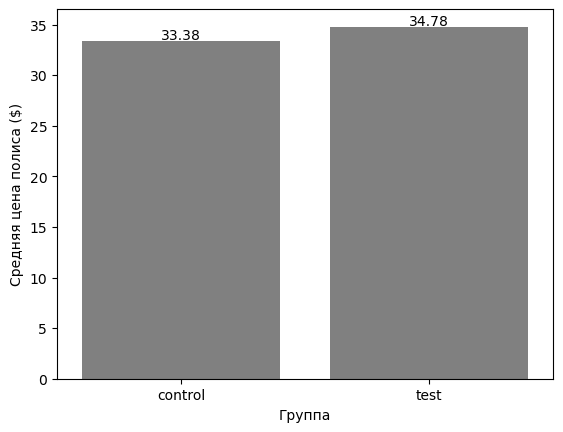

In [21]:
# Визуализируем цену полиса по группам
sns.barplot(x='group', y='avg_price', data=group, color='grey')
# Добавим подписи сверху столбцов
for i in range(2):
    plt.text(x=i, y=group['avg_price'][i]+0.2, s=round(group['avg_price'][i],2), horizontalalignment='center')
plt.xlabel('Группа')
plt.ylabel('Средняя цена полиса ($)')
plt.show()

## **Убыточность**
### - H0: Убыточность контрольной и тестовой группы не отличается
### - H1: Убыточность контрольной и тестовой группы отличается

In [22]:
group

,group,client_id,price_usd,insurance_amount_usd,loss_payout_amt_usd,loss_cnt,converted,conversion_rate,avg_price,avg_insurance_amount,avg_loss_payout_amt
0,control,6043,65064,92337500,79750,30,1949,0.322522,33.383273,47376.859928,2658.333333
1,test,6306,57982,64662500,92375,14,1667,0.264351,34.782244,38789.742052,6598.214286


In [23]:
# Проведём t-тест для проверки гипотезы о равенстве убыточности в группах
control_loss = df[(df['group'] == 'control') & (df['converted'] == 1)]['loss_payout_amt_usd']
test_loss = df[(df['group'] == 'test') & (df['converted'] == 1)]['loss_payout_amt_usd']
alpha = 0.01

stats, pvalue = st.ttest_ind(control_loss, test_loss, equal_var = False)

print('p-value равно', pvalue)

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value равно 0.6156632574348682
Не получилось отвергнуть нулевую гипотезу


In [24]:
# На сколько процентов изменилась убыточность в тестовой группе по отношению к контрольной
control = group['loss_payout_amt_usd'][0]
test = group['loss_payout_amt_usd'][1]
print(f'Убыточность в тестовой группе на {round((test/control-1)*100, 2)}% выше, чем в контрольной')

Убыточность в тестовой группе на 15.83% выше, чем в контрольной


In [25]:
# На сколько процентов изменилась средняя убыточность в тестовой группе по отношению к контрольной
control = group['avg_loss_payout_amt'][0]
test = group['avg_loss_payout_amt'][1]
print(f'Средняя убыточность в тестовой группе на {round((test/control-1)*100, 2)}% выше, чем в контрольной')

Средняя убыточность в тестовой группе на 148.21% выше, чем в контрольной


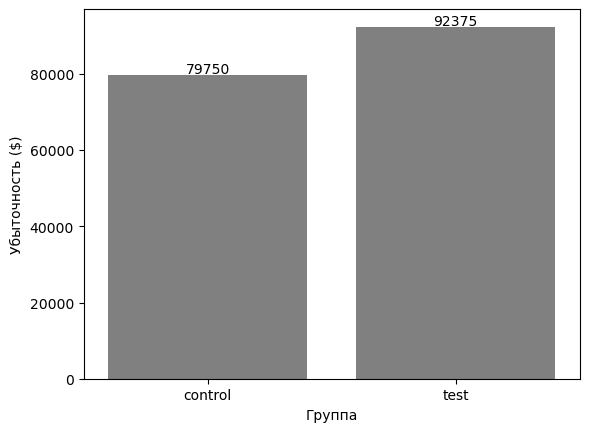

In [26]:
# Визуализируем убыточность по группам
sns.barplot(x='group', y='loss_payout_amt_usd', data=group, color='grey')
# Добавим подписи сверху столбцов
for i in range(2):
    plt.text(x=i, y=group['loss_payout_amt_usd'][i]+500, s=group['loss_payout_amt_usd'][i], horizontalalignment='center')
plt.xlabel('Группа')
plt.ylabel('Убыточность ($)')
plt.show()

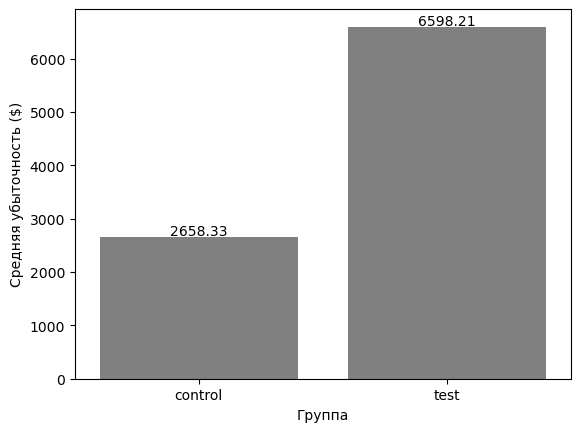

In [27]:
# Визуализируем среднюю убыточность по группам
sns.barplot(x='group', y='avg_loss_payout_amt', data=group, color='grey')
# Добавим подписи сверху столбцов
for i in range(2):
    plt.text(x=i, y=group['avg_loss_payout_amt'][i]+30, s=round(group['avg_loss_payout_amt'][i],2), horizontalalignment='center')
plt.xlabel('Группа')
plt.ylabel('Средняя убыточность ($)')
plt.show()

# Выводы:
### - Конверсия в оформления в тестовой группе на **6.0% ниже**, чем в контрольной группе.
### - Тест не показал статистически значимой разницы цен между группами.
### - Тест не показал статистически значимой разницы убыточности между группами.


# Рекомендация:
Новый кластерный подход, похоже, не дает каких-либо существенных преимуществ по сравнению с традиционным методом оценки рисков. Учитывая снижение коэффициента конверсии и отсутствие явных улучшений в ценообразовании и убытках, переход на кластерный подход может оказать негативное влияние на бизнес, потенциально снижая доходы и доверие клиентов. Поэтому рекомендуется продолжать использовать традиционный подход к оценке рисков для определения стоимости полисов ВЗР. Если компания по-прежнему заинтересована в изучении кластерного подхода, потребуются дальнейшие исследования и уточнения, прежде чем рассматривать его внедрение.